# PRUEBA DE CARGO PARA LÍDER DE LÍNEA DE CONOCIMIENTO EN IA

## EDA y conclusiones sobre los datos

In [1]:
# import initial modules
import pandas as pd
import plotly.express as px
import numpy as np
pd.set_option('display.max_columns', None)
import json
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dython.nominal import associations
import seaborn as sns
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


c:\Users\ASUS\Desktop\prueba_lider_ia\challenge_ia_ml_test\venv\Lib\site-packages\dython\__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
#############################################
###### Parameters for the execution #########
#############################################

# Get the absolute path to the directory where the script is located
script_dir = os.getcwd()
script_dir = script_dir.replace('\\','/')

# staging data path
stg_data_path = f"{script_dir}/../../data/staging/restaurants_dataset.parquet"
anal_data_path = f"{script_dir}/../../data/analitycs/preprocessed_dataset/restaurants_dataset.parquet"

In [3]:
# load the staging data for the analisys
data_stg = pd.read_parquet(stg_data_path)

In [4]:
# explore the format and content of the variable to see the possible 
data_stg.head()

,Registration Number,Annual Turnover,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,Liquor License Obtained,Situated in a Multi Complex,Dedicated Parking,Open Sitting Available,Resturant Tier,Restaurant Type,Restaurant Theme,Restaurant Zomato Rating,Restaurant City Tier,Order Wait Time,Staff Responsivness,Value for Money,Hygiene Rating,Food Rating,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,42000000,"indian,irish",bangalore,near business hub,2009-02-14,84.3,not specific,95.8,1,1,1,0,1,2,bar,arabian,3,0,2,5,5,5,7,10,4,<NA>,<NA>,<NA>,8,8,6,6,6
1,60002,50000000,"indian,irish",indore,near party hub,2008-09-29,85.4,tier a celebrity,85.0,1,1,1,1,0,2,bar,greek,3,0,6,6,6,7,8,9,<NA>,4,<NA>,<NA>,5,7,7,3,8
2,60003,32500000,"tibetan,italian",chennai,near business hub,2011-07-30,85.0,tier a celebrity,68.2,1,1,1,1,0,2,bar,90's,3,0,2,6,5,3,7,8,3,<NA>,<NA>,<NA>,7,10,5,2,8
3,60004,110000000,"turkish,nigerian",gurgaon,near party hub,2008-11-30,85.6,tier a celebrity,83.6,0,1,1,1,1,1,bar,arabian,3,1,7,6,5,6,8,9,6,<NA>,<NA>,<NA>,7,7,4,3,5
4,60005,20000000,"irish,belgian",manesar,near party hub,2010-02-22,NaN,tier a celebrity,76.8,1,1,1,1,1,<NA>,bar,greek,3,0,10,5,6,4,8,6,<NA>,2,<NA>,<NA>,<NA>,6,2,4,6


In [5]:
# categorical and numerical vars
CATEGORICAL_VARS = ['Cuisine','City','Endorsed By','Restaurant Type','Restaurant Theme','Restaurant Location']
NUMERICAL_VARS = set(data_stg.columns)-set(CATEGORICAL_VARS + ['Registration Number'])

### Análisis de variables categóricas

In [6]:
# number of unique values in cat cols
data_stg[CATEGORICAL_VARS].describe()

,Cuisine,City,Endorsed By,Restaurant Type,Restaurant Theme,Restaurant Location
count,3493,3493,3493,3493,3493,3493
unique,20,194,3,4,34,2
top,"tibetan,greek",bangalore,not specific,bar,arabian,near party hub
freq,686,585,1961,3235,1373,2658


Se excluye la variable "City" del análisis de concurrencia dado que tiene una cantidad elevada de valores únicos.

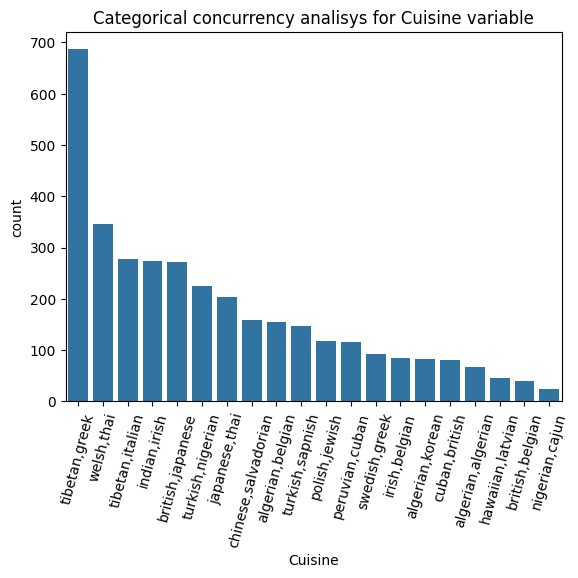

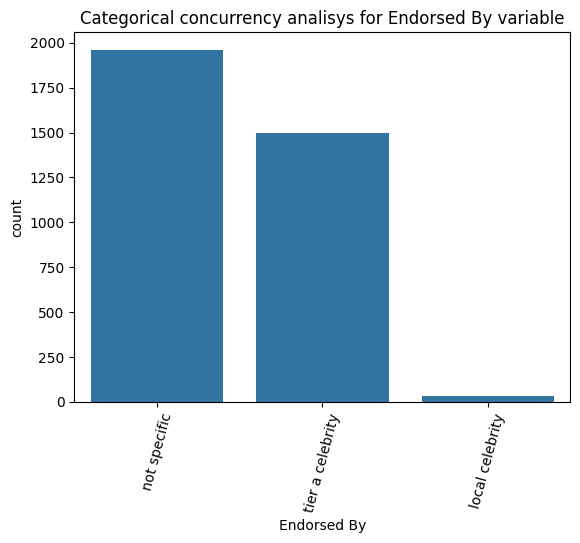

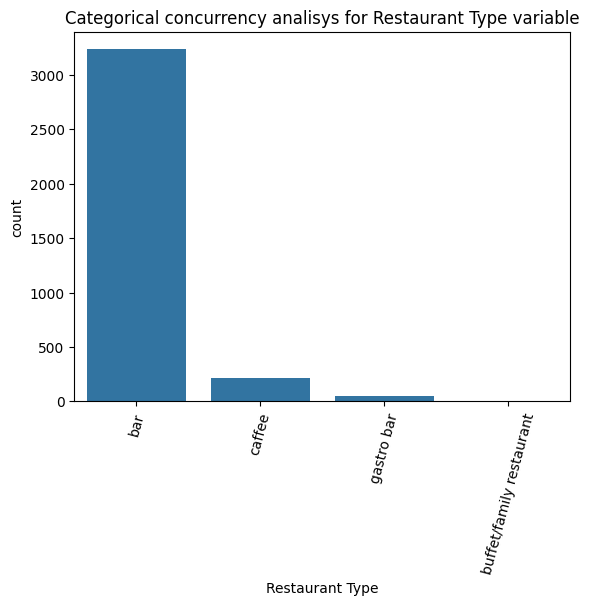

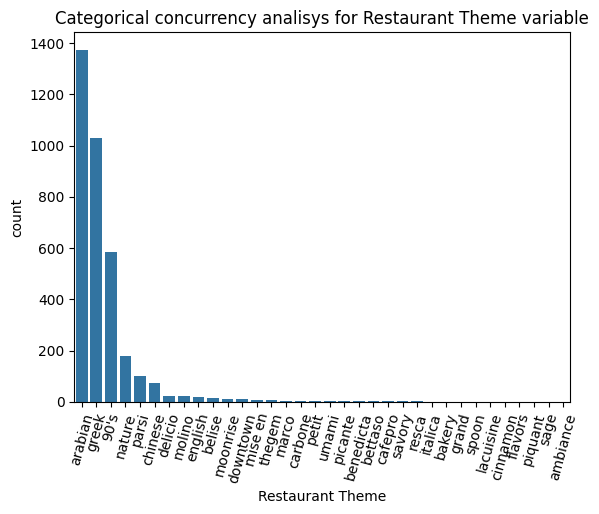

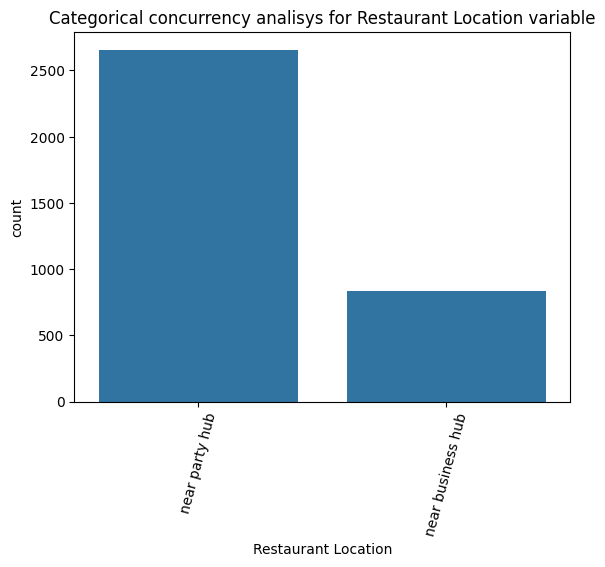

In [7]:
# variables excluded form the concurrency analisys
EXCLUDED_VARS = ["City"]

# categorical vars concurrency analisys just for the
for cat_col in CATEGORICAL_VARS:
    if cat_col not in EXCLUDED_VARS:
        value_count_temp = data_stg[cat_col].value_counts().reset_index()
        sns.barplot(x=cat_col,y='count',data=value_count_temp)
        plt.title(f"Categorical concurrency analisys for {cat_col} variable")

        plt.xticks(rotation=75)  # Rotate x labels vertically
        plt.show()

De estos gráficos podemos extraer una serie de observaciones: 
- El gráfico muestra que el tema del restaurante tiene una gran concentración en las primeras 6 categorías y las otras parecen ser más categorías de nicho.
- Gran parte de los restaurantes en esta lista corresponden a bares.
- Los restaurantes o son respaldados por una celebridad o no tienen ningún respaldo específico.
- En cuanto al tipo de cocina, si bien la más común es la "tibetan, greek" hay bastante variabilidad en este sentido.
- Gran parte de los restaurantes están cerca a sitios de fiesta.

Dado esto, se va a proceder a hacer una serie de modificaciones sobre los datos, con el fin de tener un análisis más diciente y potencialmente, mejorar el desempeño de los modelos que se van a desarrollar posteriormente.
- Agrupar todos los temas de restaurante que tengan menos concurrencia que el chino en una misma categoría llamada "otros".
- Eliminar los restaurantes que están en la categoría "buffet/family restaurant".
- Agrupar la variable "Endorsed By" para que solo sea si es o no recomendado por una celebridad.

In [8]:
# replace the restaurant themes with low ocurrency for 1 category ("others")
themes_og = data_stg['Restaurant Theme'].value_counts().reset_index()
themes_og = themes_og[(themes_og['count'])>=int(themes_og[(themes_og['Restaurant Theme']=="chinese")]['count'])]['Restaurant Theme'].tolist()
data_stg['restaurant_theme_mod'] = [i if i in themes_og else "others" for i in data_stg['Restaurant Theme']]

# drop the restaurants with restaurant type == "buffet/family restaurant"
data_stg = data_stg[data_stg["Restaurant Type"] != "buffet/family restaurant"]

# group the Endorsed by variable
data_stg['Endorsed By'] = [i if i=='not specific' else 'celebrity' for i in data_stg['Endorsed By']]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\1164141223.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  themes_og = themes_og[(themes_og['count'])>=int(themes_og[(themes_og['Restaurant Theme']=="chinese")]['count'])]['Restaurant Theme'].tolist()


In [9]:
# remove the variable without the trasnformation and add the transformed
CATEGORICAL_VARS.remove('Restaurant Theme')
CATEGORICAL_VARS.append('restaurant_theme_mod')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2612162350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')


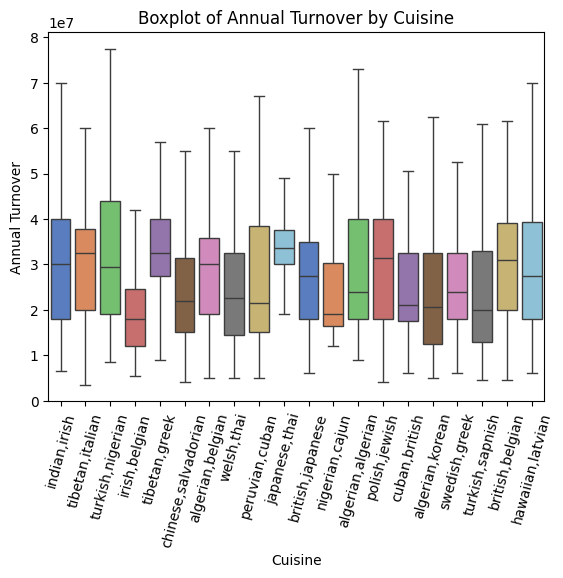

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2612162350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')


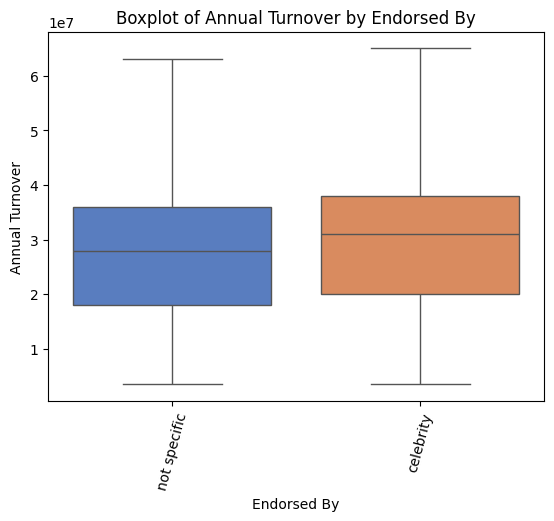

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2612162350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')


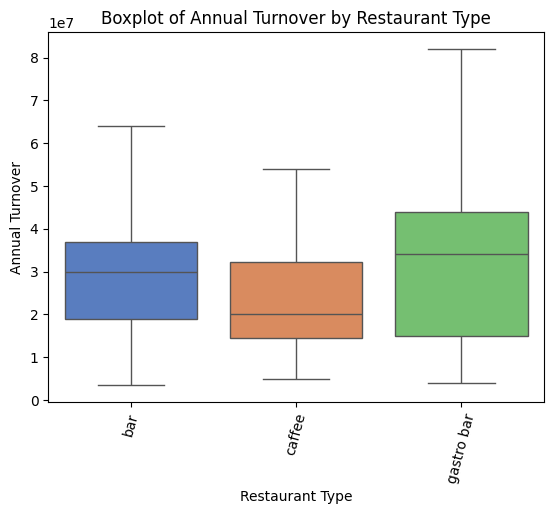

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2612162350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')


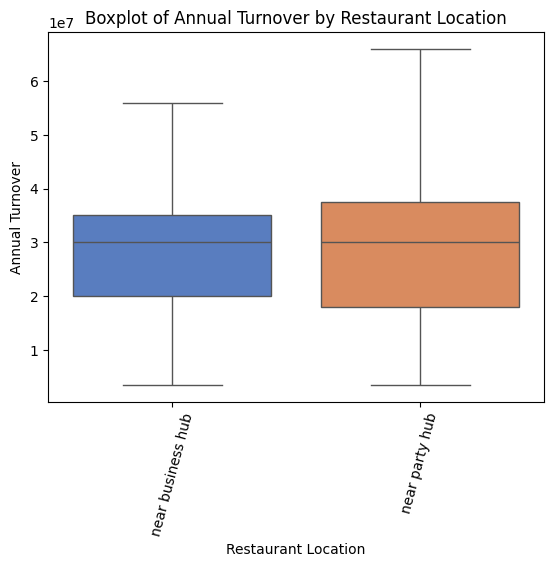

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2612162350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')


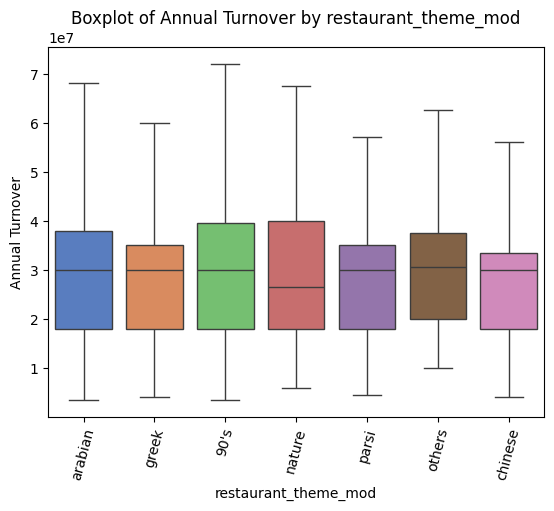

In [10]:
# excluded vars for the analisys
EXCLUDED_VARS = ['City']

# Boxplot of categorical variables versus the objective variable
for cat_var in CATEGORICAL_VARS:
    if cat_var not in EXCLUDED_VARS:
        sns.boxplot(x=cat_var, y="Annual Turnover", showfliers=False, data=data_stg,palette='muted')

        plt.title(f"Boxplot of Annual Turnover by {cat_var}")
        plt.xlabel(f"{cat_var}")
        plt.ylabel("Annual Turnover")
        plt.xticks(rotation=75)
        plt.show()

De la gráfica anterior la relación que más llama la atención es que el tipo de cocina "japanese, thai" y "tibetan, greek" parecen percibir un annual turnover mayor que las demás clases, sin embargo, es pertinente hacer una prueba ANOVA para ver si efectivamente la variable categórica tiene una correlación importante con la variable objetivo.

Además, parece que el hecho de que el restaurante sea recomendado por una celebridad tiene un efecto positivo en el Annual Turnover y si bien el hecho de que el restaurante sea un gastro-bar parece tener un efecto positivo, la cantidad de restaurantes que tienen esta característica son muy pocos para poder ser incluido como una conclusión del análisis.

In [11]:
# ANOVA analisys for Cuisine variable
data_stg["annual_turnover"] = data_stg["Annual Turnover"]

# Ajustar modelo ANOVA
modelo = ols('annual_turnover ~ C(Cuisine)', data=data_stg).fit()
anova_tabla = sm.stats.anova_lm(modelo, typ=2)
print(anova_tabla)

                  sum_sq      df         F        PR(>F)
C(Cuisine)  4.466332e+16    19.0  5.126427  2.495419e-12
Residual    1.592071e+18  3472.0       NaN           NaN


Dados los resultados de la prueba ANOVA, el p-valor que se encuentra es 2.49 e-12, lo cual es mucho menor que el valor crítico de 0,05. Lo cual indica que con un 95% de confianza, se rechaza la hipótesis nula de que no hay diferencia significativa entre la media de la variable para los diferentes grupos, por lo que la variable puede ser importante al momento de estimar el Annual Turnover.

Ahora, para obtener cuáles de las categorías son diferentes, se hace una prueba de Tukey HSD.

In [12]:
# tukey hsd after the anova test to see which variables have a significative difference in their means
tukey = pairwise_tukeyhsd(endog=data_stg["Annual Turnover"], groups=data_stg["Cuisine"], alpha=0.05)

# Convert result to a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# Filter only rows where reject == True
significant_results = tukey_df[tukey_df["reject"] == True]

sign_corr_variables = set(significant_results['group1'].tolist() + significant_results['group2'].tolist())

significant_results

,group1,group2,meandiff,p-adj,lower,upper,reject
86,"chinese,salvadorian","hawaiian,latvian",1.466762e+07,0.0069,1.953088e+06,2.738216e+07,True
89,"chinese,salvadorian","japanese,thai",9.388319e+06,0.0055,1.354154e+06,1.742248e+07,True
94,"chinese,salvadorian","tibetan,greek",9.101740e+06,0.0003,2.416324e+06,1.578716e+07,True
96,"chinese,salvadorian","turkish,nigerian",9.835933e+06,0.0016,1.967706e+06,1.770416e+07,True
113,"hawaiian,latvian","irish,belgian",-1.682685e+07,0.0030,-3.072793e+07,-2.925781e+06,True
122,"hawaiian,latvian","turkish,sapnish",-1.302425e+07,0.0419,-2.585471e+07,-1.937960e+05,True
123,"hawaiian,latvian","welsh,thai",-1.366667e+07,0.0076,-2.558735e+07,-1.745988e+06,True
134,"indian,irish","welsh,thai",-6.152094e+06,0.0500,-1.230393e+07,-2.628562e+02,True
135,"irish,belgian","japanese,thai",1.154755e+07,0.0048,1.743049e+06,2.135205e+07,True
140,"irish,belgian","tibetan,greek",1.126097e+07,0.0009,2.527403e+06,1.999454e+07,True


En la tabla anterior se observan las categorías de la variable "Cuisine" que tienen una diferencia estadísticamente significativa entre las medias de las variables, las cuales podrían ser de bastante utilidad para desarrollar posteriormente el feature engineering.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5008\2333342550.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cuisine", y="Annual Turnover", showfliers=False, data=data_stg[data_stg['Cuisine'].isin(sign_corr_variables)],palette='muted')


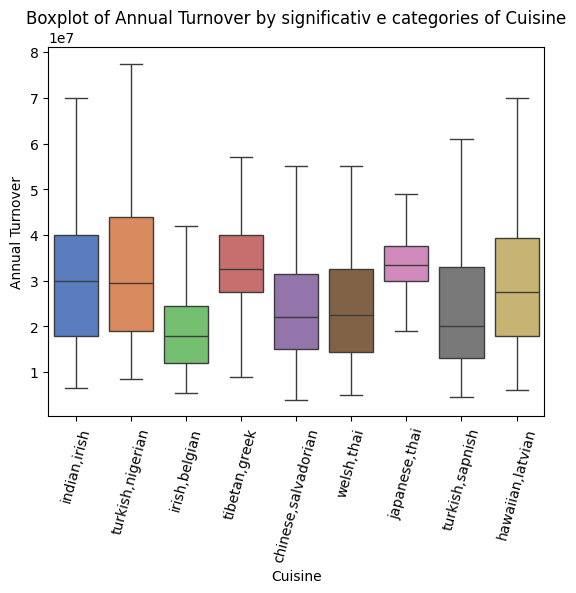

In [13]:
# variables with significative mean diff
sign_corr_variables

# boxplot for just the significative categories
sns.boxplot(x="Cuisine", y="Annual Turnover", showfliers=False, data=data_stg[data_stg['Cuisine'].isin(sign_corr_variables)],palette='muted')
plt.title("Boxplot of Annual Turnover by significativ e categories of Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Annual Turnover")
plt.xticks(rotation=75)
plt.show()

### Análisis de variables numéricas

In [14]:
# numerical vars describe
NUMERICAL_VARS = list(NUMERICAL_VARS)
date_var = NUMERICAL_VARS.pop(NUMERICAL_VARS.index("Opening Day of Restaurant"))
data_stg[NUMERICAL_VARS].describe()

,Liquor License Obtained,Overall Restaurant Rating,Situated in a Multi Complex,Live Music Rating,Resturant Tier,Facebook Popularity Quotient,Staff Responsivness,Open Sitting Available,Instagram Popularity Quotient,Order Wait Time,Lively,Annual Turnover,Ambience,Restaurant Zomato Rating,Dedicated Parking,Fire Audit,Hygiene Rating,Value for Money,Comedy Gigs Rating,Restaurant City Tier,Value Deals Rating,Comfortablility,Food Rating,Privacy,Live Sports Rating,Service
count,3492.000000,3281.0,3492.000000,2727.0,3443.0,3393.000000,3492.000000,3492.000000,3436.000000,3492.000000,3492.000000,3.492000e+03,3467.0,3492.000000,3492.000000,3492.000000,3492.000000,3492.000000,1010.0,3492.000000,786.0,3492.000000,3492.000000,3492.000000,205.0,3492.000000
mean,0.988259,8.479427,0.808133,4.012468,1.926808,77.940171,4.538373,0.800115,74.412602,5.510023,6.876575,3.072133e+07,6.423132,2.696163,0.801833,0.788660,4.661798,4.526060,2.932673,0.301546,3.655216,3.231959,7.523482,6.275773,3.590244,4.547824
std,0.107734,1.287233,0.393826,1.009052,0.260489,9.830252,1.093961,0.399971,10.932066,2.854770,1.844717,2.165280e+07,2.05031,0.787075,0.398676,0.408318,1.259690,0.913727,0.859519,0.458995,0.97325,1.992978,1.722438,1.894937,0.906351,1.876372
min,0.000000,6.0,0.000000,1.0,1.0,43.000000,1.000000,0.000000,40.000000,1.000000,0.000000,3.500000e+06,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,1.0,0.000000,5.000000,0.000000,2.0,0.000000
25%,1.000000,7.0,1.000000,3.0,2.0,72.000000,4.000000,1.000000,66.112500,3.000000,6.000000,1.800000e+07,5.0,2.000000,1.000000,1.000000,4.000000,4.000000,2.0,0.000000,3.0,2.000000,6.000000,5.000000,3.0,3.000000
50%,1.000000,9.0,1.000000,4.0,2.0,79.000000,5.000000,1.000000,74.085000,5.000000,7.000000,3.000000e+07,7.0,3.000000,1.000000,1.000000,5.000000,5.000000,3.0,0.000000,4.0,3.000000,7.000000,6.000000,4.0,5.000000
75%,1.000000,10.0,1.000000,5.0,2.0,85.750000,5.000000,1.000000,82.400000,8.000000,8.000000,3.700000e+07,8.0,3.000000,1.000000,1.000000,6.000000,5.000000,3.0,1.000000,4.0,5.000000,9.000000,8.000000,4.0,6.000000
max,1.000000,10.0,1.000000,8.0,2.0,97.760000,8.000000,1.000000,98.700000,10.000000,10.000000,4.000000e+08,10.0,5.000000,1.000000,1.000000,9.000000,7.000000,6.0,1.000000,7.0,10.000000,10.000000,10.000000,6.0,10.000000


Tal como se había observado en el Jupyter anterior, dado que "Live Sports Rating" contiene tantos valores nulos, se va a transformar a una variable binaria que indique si tiene o no rating por deportes en vivo.

In [15]:
# transform Live Sports Rating varible
data_stg['has_live_sports'] = [1 if (i in range(1,10)) else 0 for i in data_stg['Live Sports Rating'].fillna(0)]
NUMERICAL_VARS.pop(NUMERICAL_VARS.index('Live Sports Rating'))
NUMERICAL_VARS.append('has_live_sports')

# Get binary and Numeric variables
count_dataset = data_stg[NUMERICAL_VARS].nunique().reset_index()
count_dataset.columns = ["variable","nunique"]
count_dataset = count_dataset.sort_values("nunique")
binary_vars = count_dataset[count_dataset['nunique']<=2]['variable'].tolist()
NUMERICAL_VARS = count_dataset[~(count_dataset['nunique']<=2)]['variable'].tolist()

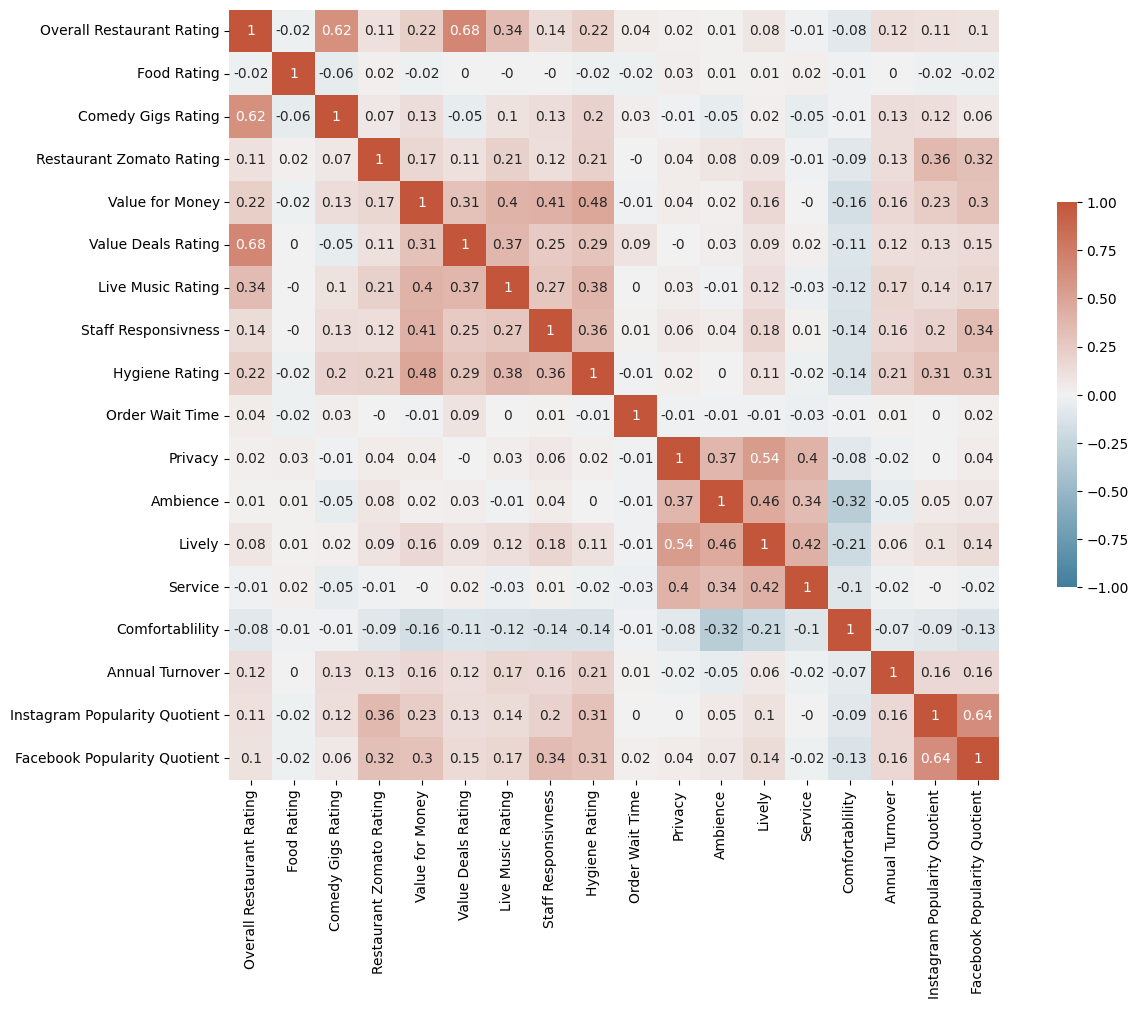

In [16]:
# correlation matrix for the numerical variables
correlation_table = data_stg[NUMERICAL_VARS].corr()

for col in correlation_table.columns:
    correlation_table[col] = [round(i,2) for i in correlation_table[col]]

# correlation matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(15,10))
sns.heatmap(correlation_table,cmap=cmap, square=True, cbar_kws={"shrink": .5},vmax=1, center=0,vmin=-1, annot=True)
plt.show()

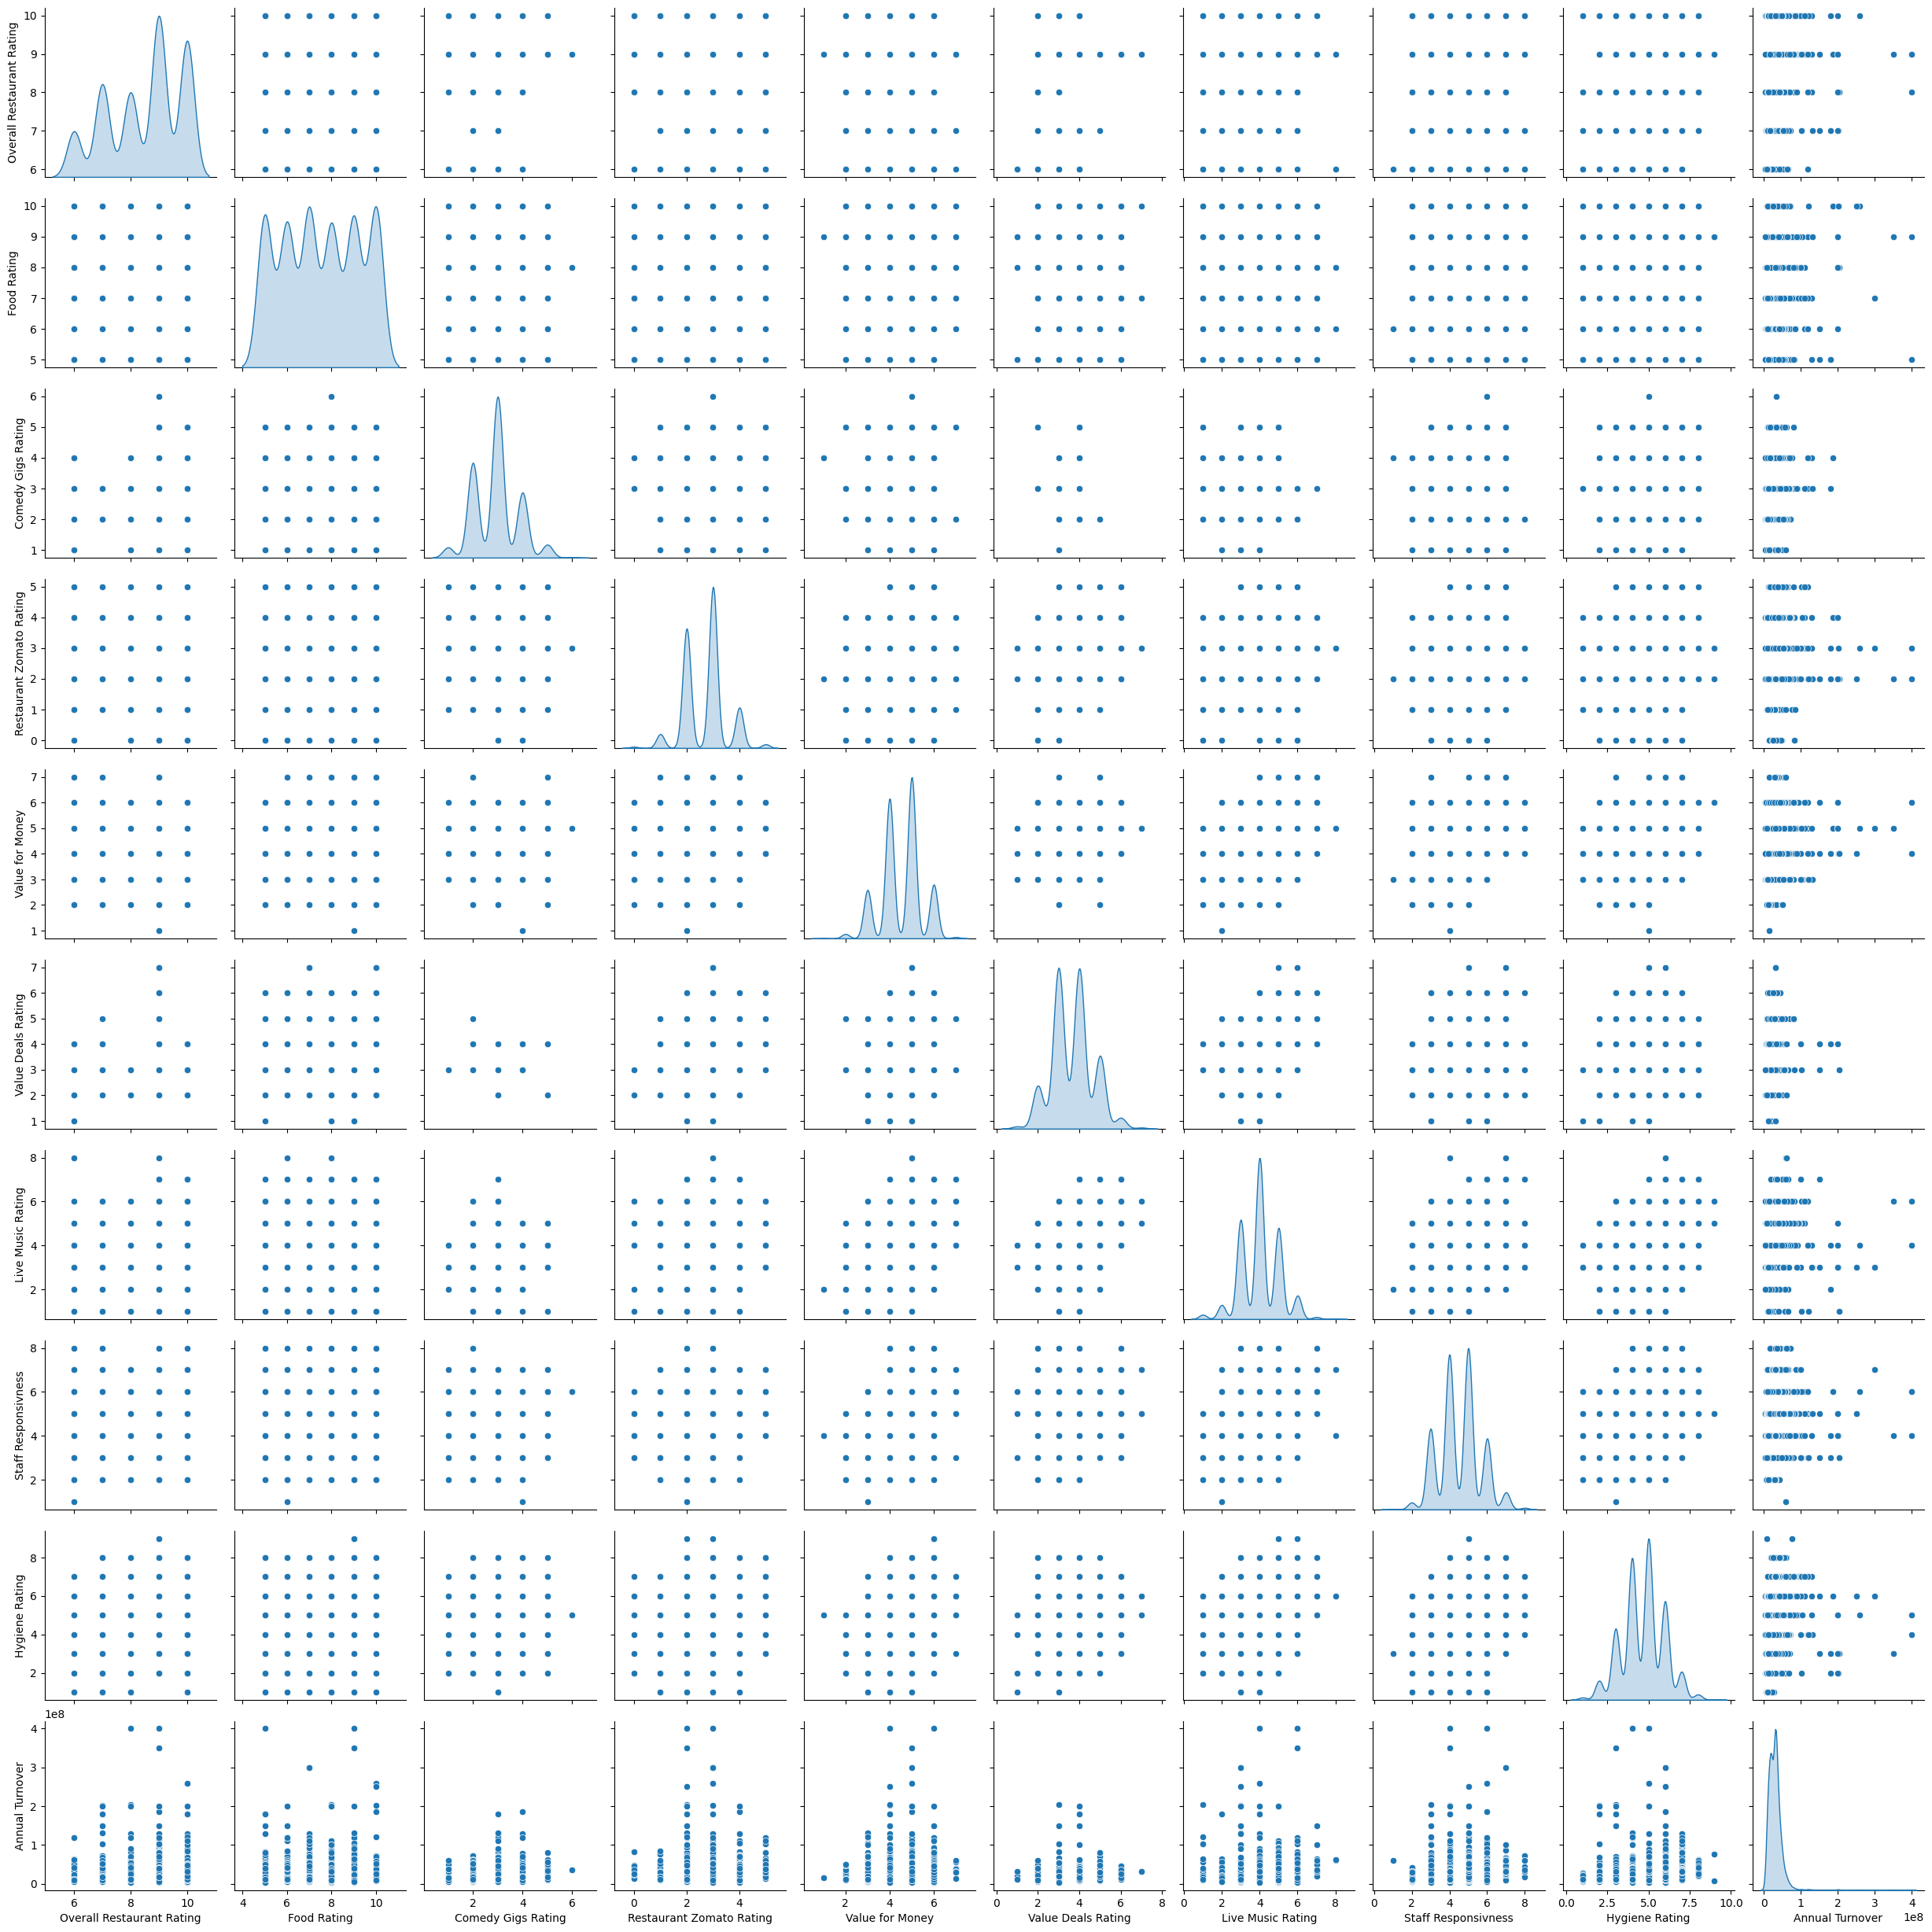

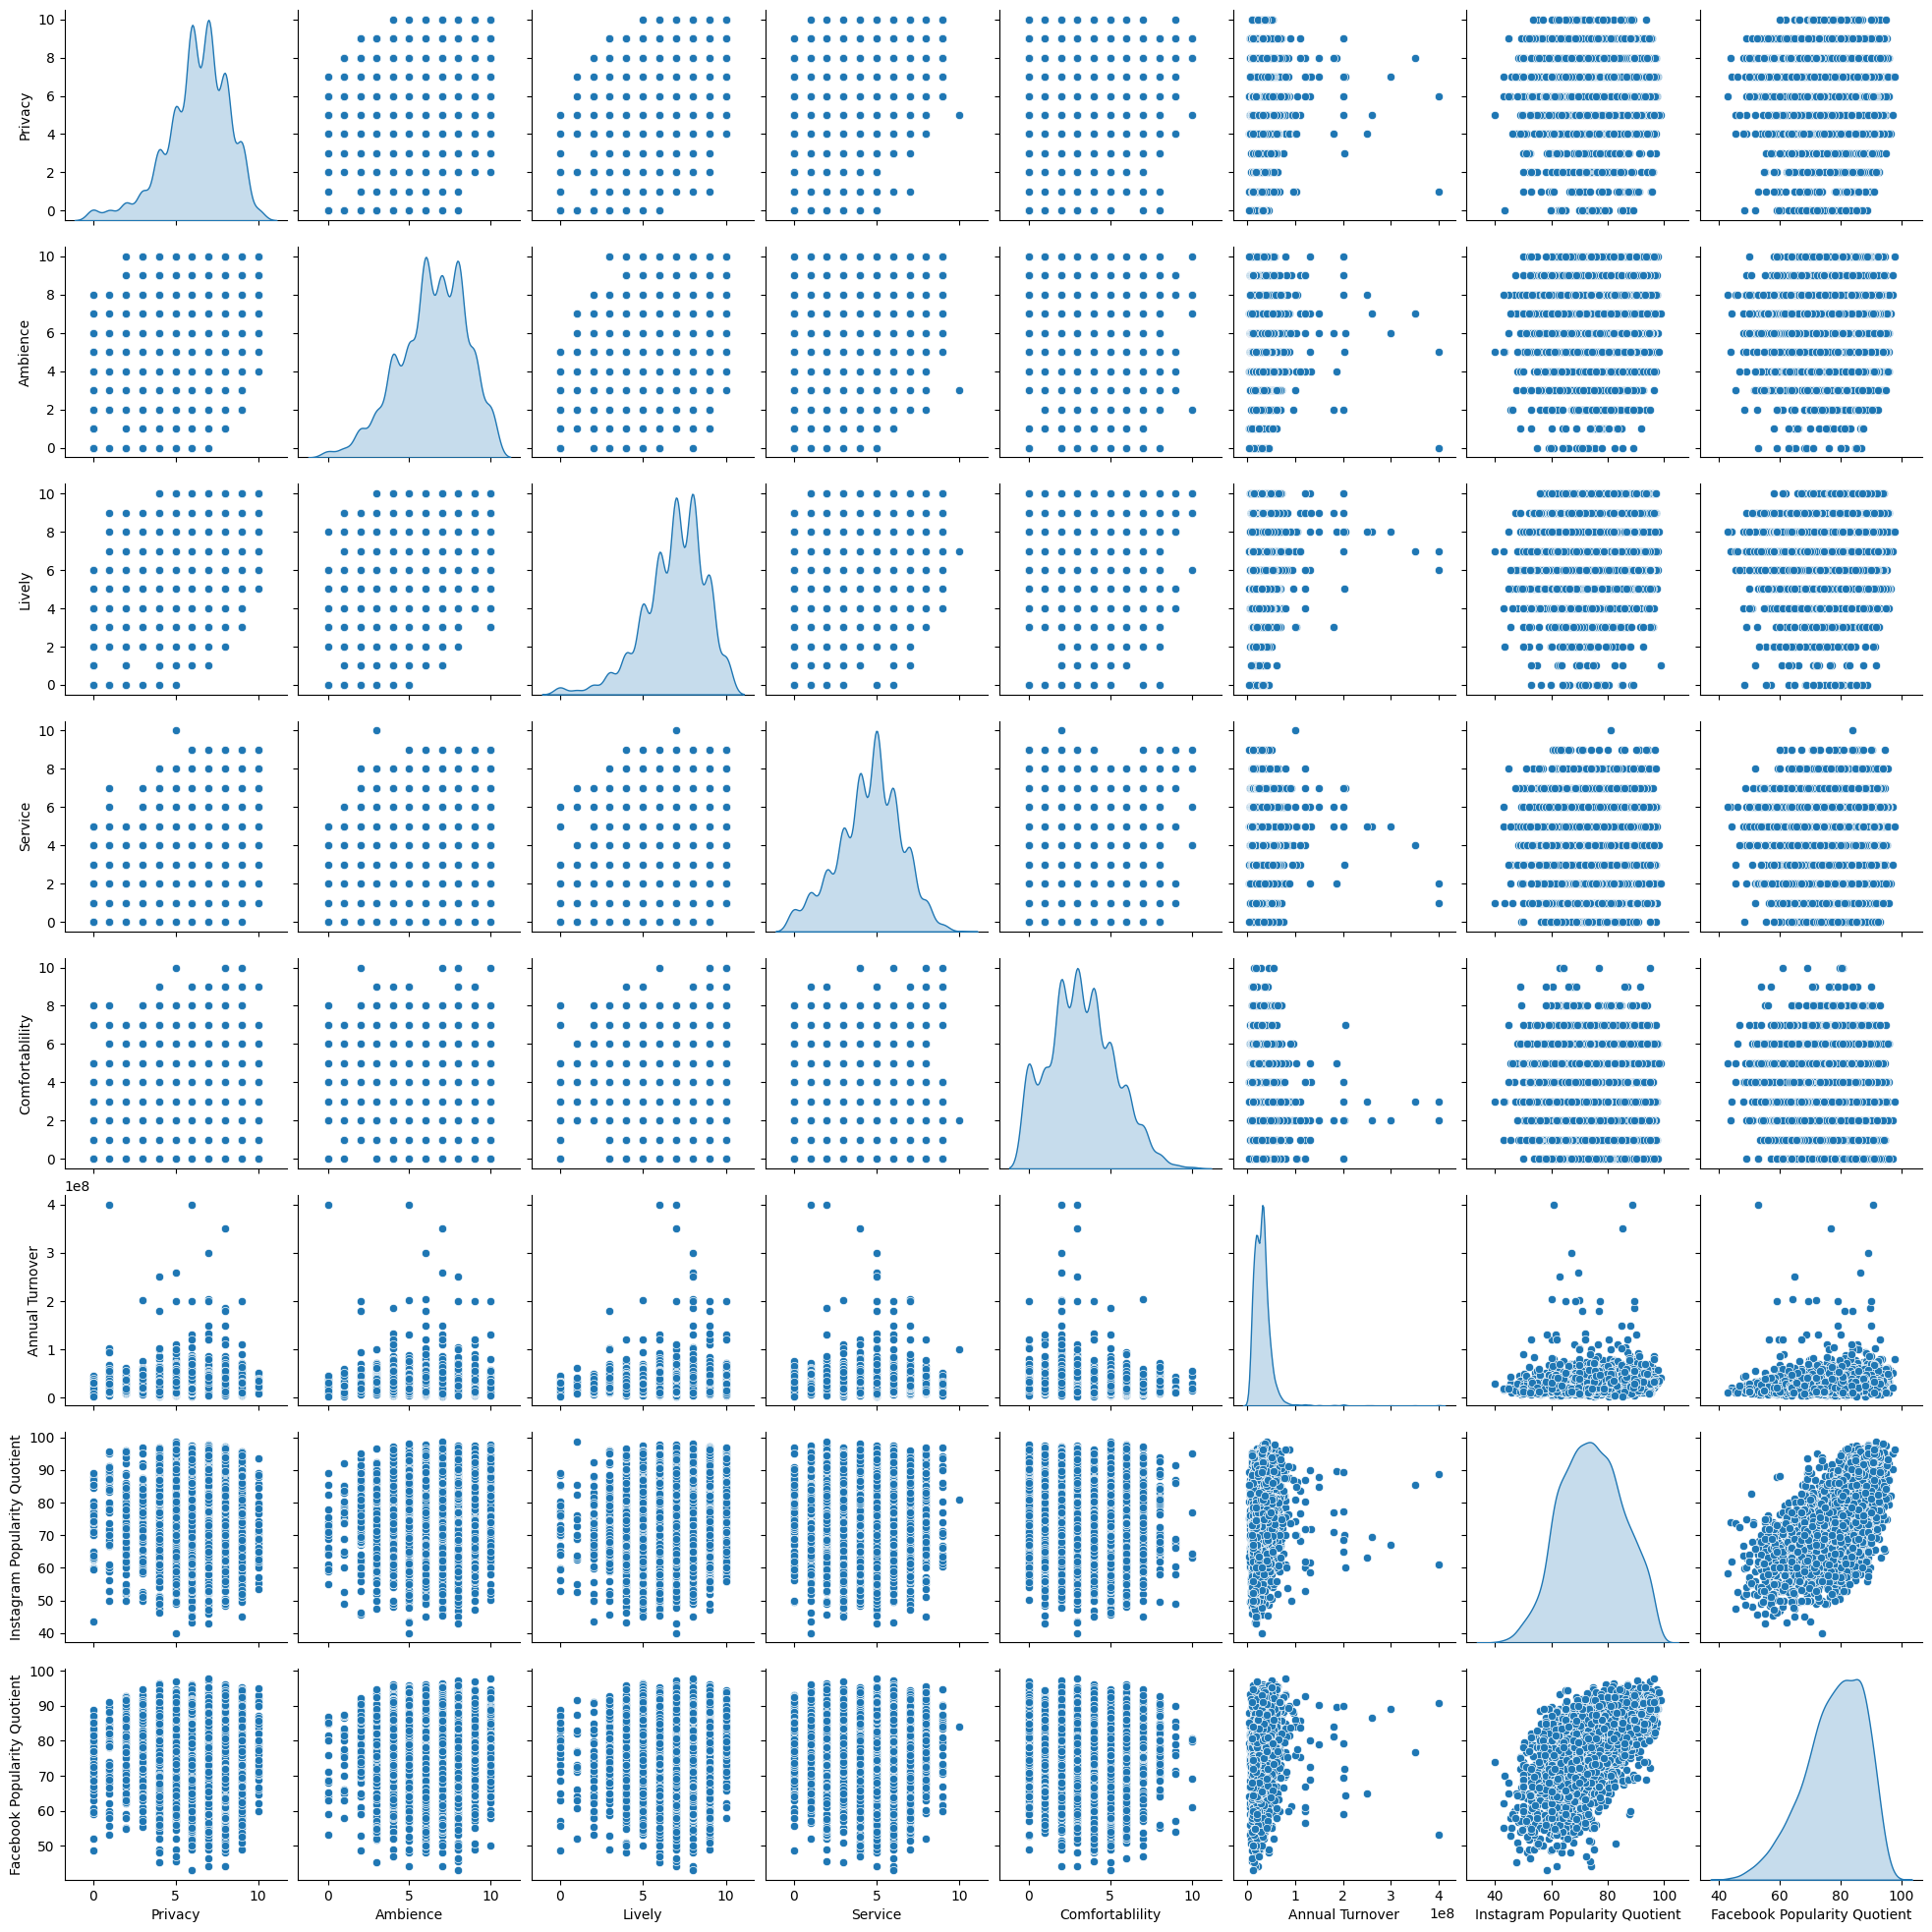

In [17]:
# histogram and correlation scatter plot for numerical variables
sns.pairplot(data_stg[NUMERICAL_VARS[0:9]+["Annual Turnover"]], diag_kind="kde")
plt.show()

sns.pairplot(data_stg[NUMERICAL_VARS[10:]], diag_kind="kde")
plt.show()

Del análisis anterior se puede observar que a excepción de 3 variables, todas las variables numéricas del dataset corresponden a variables discretas y las que no lo son son la variable objetivo y las dos variables que corresponden a coeficientes de popularidad en Facebook e Instagram.

Por lo tanto, dado que todas las variables de rating están definidas entre 0 y 10, el análisis de outliers solo se tiene que realizar sobre la variable objetivo y sobre las variables de coeficientes cuando se quieran implementar los modelos.

Por último, tanto en el gráfico de correlaciones como en el scatter, se puede observar que ninguna variable tiene una correlación alta con la variable objetivo. Además, no parece haber ninguna forma funcional definida entre las variables explicativas y la variable a explicar, por lo que probablemente lo más adecuado sea utilizar un modelo supervisado no paramétrico multivariado.

También vale la pena mencionar que tal como se muestra en el coeficiente de correlación de Pearson, hay una alta correlación entre el coeficiente de popularidad en Facebook y el de Instagram; sin embargo, no es lo suficientemente alta como para considerar eliminar alguna de las variables del analisís.

Además, aunque la mayoría de variables explicativas son discretas, se puede observar que casi todas ellas tienen una distribución que se asemeja a una campana Gaussiana, lo cual puede ser positivo tanto para los modelos como para las pruebas de hipótesis. Incluso las variables de coeficientes tienen una distribución Gaussiana, aun cuando el coeficiente de Facebook puede presentar un poco de oblicuidad ("Skewness").

### Tratamiento de valores atípicos

Cantidad de restaurantes con un Annual Turnover a por lo menos 3 desviaciones de la media: 36


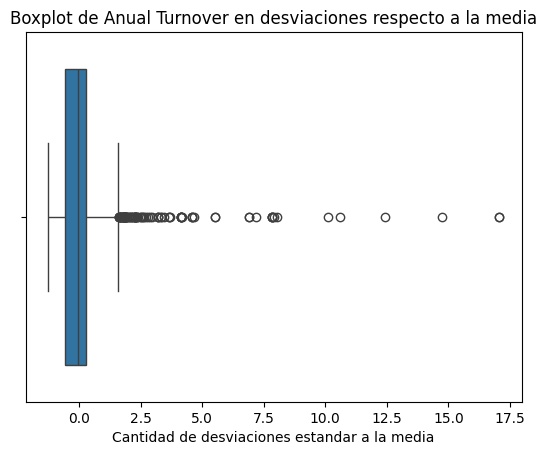

In [18]:
# Z score analisys fot objetive variable
mean_ann_turn = data_stg['Annual Turnover'].mean()
std_ann_turn = data_stg['Annual Turnover'].std()
data_stg['temp_ann_turn_std_dev'] = (data_stg['Annual Turnover']- mean_ann_turn)/std_ann_turn

# num of outliers
print("Cantidad de restaurantes con un Annual Turnover a por lo menos 3 desviaciones de la media:",sum(data_stg['temp_ann_turn_std_dev']>=3) )

# outlier detection on objetive variable
sns.boxplot(x=data_stg['temp_ann_turn_std_dev'])
plt.xlabel("Cantidad de desviaciones estandar a la media")
plt.title("Boxplot de Anual Turnover en desviaciones respecto a la media")
plt.show()

Vemos que hay por lo menos 36 datos cuyo valor está más de 3 desviaciones estándar por encima de la media, por lo que estos datos se van a imputar con el valor correspondiente al límite de 3 desviaciones estándar arriba de la media, con el fin de que el modelo tenga el mejor desempeño posible.

In [19]:
# inputing the outliers with the value at 3 standard deviations but save a copy of the original variable for testing
data_stg['Annual Turnover backup'] = data_stg['Annual Turnover']
data_stg['Annual Turnover'] = [i if ((i-mean_ann_turn)/std_ann_turn) <= 3 else (3*std_ann_turn)+mean_ann_turn for i in data_stg['Annual Turnover']]

### EDA para variables binarias

In [20]:
# amount of null values in Restaurant Tier
print("null count in Resturant Tier",sum((data_stg['Resturant Tier'].isna())))

# replace null values with the lowest mode of the variable
data_stg['Resturant Tier'] = data_stg['Resturant Tier'].fillna(int(data_stg['Resturant Tier'].mode()[0]))

null count in Resturant Tier 49


In [21]:
# replace the discrete values of Resturant Tier for 1 and 0
res_max = data_stg['Resturant Tier'].max()
data_stg['Resturant Tier'] = [1 if i==res_max else 0 for i in data_stg['Resturant Tier']]

In [22]:
# melt the dataset to graph the difference in the binnary variables
melted_dataset = data_stg[binary_vars+["Annual Turnover"]].melt(id_vars=["Annual Turnover"],value_vars=binary_vars)

# graph a boxplot with the diference in the annual turnover for binary variables
fig = px.box(melted_dataset, x="variable", y="Annual Turnover", color="value",title="Difference in distribution for Annual Turnover beetween binnary variables")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()
fig.write_html(f"{script_dir}/boxplot_visualization.html")

**AL SER REALIZADO CON PLOTLY.EXPRESS, ESTE ANALISÍS NO SE PUEDE RENDERIZAR NI EN EL .IPYNB NI EN EL HTML A MENOS DE QUE SE EJECUTE EL JUPYTER, POR LO TANTO E ADJUNTA EN FORMATO HTML BAJO EL NOMBRE "boxplot_visualization.html". ESTE ARCHIVO DEBE SER DESCARGADO Y ABIERTO EN UN NAVEGADOR PARA PODER SER RENDERIZADO**

Con el análisis anterior pareciera que tanto la variable "Resturant Tier" como la variable "Liquor License Obtained" podrían llegar a tener algún tipo de significancia a la hora de explicar diferencias en el "Annual Turnover" de los restaurantes.

### Variable de fecha

In [23]:
# Days and years since opening using the max date in the dataset as reference
now_referecne = pd.Timestamp(data_stg['Opening Day of Restaurant'].max())
data_stg['days_since_open'] = (now_referecne - data_stg['Opening Day of Restaurant']).dt.days

# we can also calculate the years since opening but doesnt make much sense because the days since opening is already capturing all the variance of the variable
# data_stg['years_since_open'] = (now_referecne - data_stg['Opening Day of Restaurant']).dt.days / 365.25

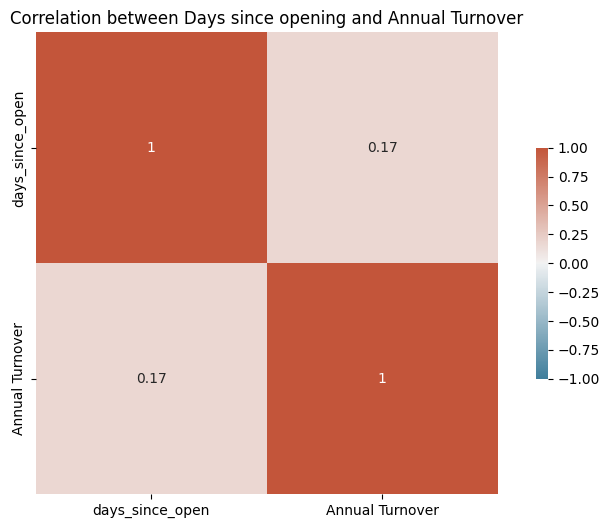

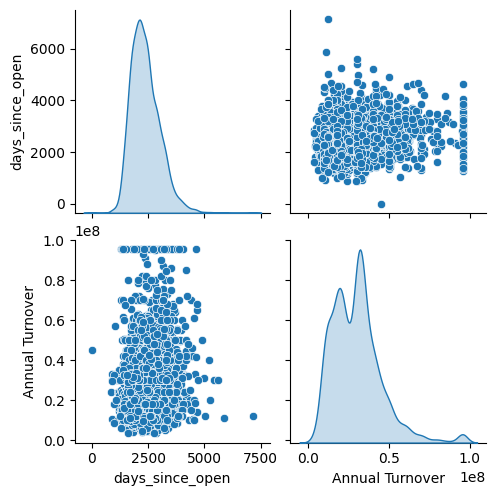

In [24]:
# show if there is a correlation between the days since opening and the annual turnover
compare_variables = ['days_since_open','Annual Turnover']

correlation_table = data_stg[compare_variables].corr()
for col in correlation_table.columns:
    correlation_table[col] = [round(i,2) for i in correlation_table[col]]

plt.figure(figsize=(10,6))
sns.heatmap(correlation_table,cmap=cmap, square=True, cbar_kws={"shrink": .5},vmax=1, center=0,vmin=-1, annot=True)
plt.title("Correlation between Days since opening and Annual Turnover")
plt.show()

sns.pairplot(data_stg[compare_variables], diag_kind="kde")
plt.show()

Se observa que no hay una correlación clara entre la antigüedad del restaurante y el "Annual Turnover" del mismo, sin embargo, se deja como una variable posible a usar, dado que en relación con las demás variables podría tener un impacto significativo

### Carga de datos a la capa de analytics con las variables a usar para el feature engineering

In [25]:
# columns to use for feature engineering
total_vars = ['Registration Number'] + CATEGORICAL_VARS + NUMERICAL_VARS + ['days_since_open'] + binary_vars + ['Annual Turnover backup']
data_stg_1 = data_stg[total_vars]

# load data to analitycs
data_stg_1.to_parquet(anal_data_path, index=False)

# load the type of the variables to a json file
type_vars = {
    "id_vars": ['Registration Number'],
    "categorical": CATEGORICAL_VARS,
    "numerical": NUMERICAL_VARS + ['Annual Turnover backup'],
    "binary": binary_vars,
    "date": ['days_since_open']
}

type_vars_path = f"{script_dir}/../../data/analitycs/preprocessed_dataset/type_vars.json"
with open(type_vars_path, 'w') as f:
    json.dump(type_vars, f, indent=4)


## Conclusiones Ejecutivas del EDA

Las siguientes conclusiones del EDA se extraen a partir del resultado tanto del analisis en el archivo de limpieza de datos de raw a staging ("../raw_to_staging/raw_to_staging_cleanup.ipynb") como del analisis que se realizo en el presente archivo.
1. **Calidad y Consistencia de los Datos**
   - El conjunto de datos presenta una estructura consistente, sin valores nulos fantasma ni variables numéricas mal tipificadas.
   - Se realizó una limpieza exhaustiva, corrigiendo errores de escritura en variables como "City" y transformando variables numéricas discretas a enteros.

2. **Variables Categóricas**
   - Se identificó que la mayoría de los restaurantes pertenecen a un grupo reducido de temas y tipos, lo que permitió agrupar categorías minoritarias bajo la etiqueta "otros".
   - La variable "Endorsed By" fue simplificada para indicar únicamente si el restaurante es recomendado por una celebridad.
   - El análisis ANOVA y Tukey HSD evidenció que el tipo de cocina ("Cuisine") tiene diferencias estadísticamente significativas en el "Annual Turnover", lo que la convierte en una variable relevante para el modelo.

3. **Variables Numéricas**
   - La mayoría de las variables numéricas son discretas y presentan distribuciones cercanas a la normalidad, lo que favorece el análisis estadístico y el desempeño de modelos supervisados.
   - No se identificaron correlaciones lineales fuertes entre las variables numéricas y el "Annual Turnover", lo que sugiere la necesidad de modelos no paramétricos y multivariados.
   - Se detectaron y trataron valores atípicos en la variable objetivo, imputando los valores extremos para mejorar la robustez del modelo.

4. **Variables Binarias**
   - Variables como "Resturant Tier" y "Liquor License Obtained" muestran potencial relevancia en la explicación de diferencias en el "Annual Turnover".

5. **Variable de Fecha**
   - La antigüedad del restaurante ("days_since_open") no presenta una correlación clara con el "Annual Turnover", pero se mantiene como variable explicativa por su posible interacción con otras variables.

6. **Limitaciones**
   - La variable "City" presenta alta cardinalidad y posibles inconsistencias, por lo que se recomienda precaución en su uso para el feature engineering.
   - El supuesto de que el "Annual Turnover" corresponde al promedio de los restaurantes registrados en una fila se mantiene ante la falta de información adicional.

### **Recomendaciones:** 
1. El modelo debe considerar principalmente las variables categóricas relevantes, las variables numéricas discretas y las binarias identificadas, aplicando técnicas de ingeniería de características

2. Dada la ausencia de correlaciones lineales fuertes, se recomienda el uso de modelos supervisados no paramétricos para capturar relaciones complejas y no lineales en los datos.

3. Se resalta también la importancia de medir la relevancia de cada una de las variables con técnicas de selección de características durante el modelado.